# Michelin Rated Restaurants in France

In [52]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import geopandas as gpd
import mapclassify
import folium
import branca

----
&nbsp;
## Import the French dataset

In [53]:
france = pd.read_csv("../../data/France/france_data.csv")
france.head(10)

,name,address,city,country,price,cuisine,url,award,stars,longitude,latitude
0,La Vague d'Or - Cheval Blanc St-Tropez,"Plage de la Bouillabaisse, Saint-Tropez, 83990...",Saint-Tropez,France,€€€€,"Creative, Modern Cuisine",https://www.chevalblanc.com/fr/maison/st-tropez/,3 MICHELIN Stars,3.0,6.626154,43.266585
1,René et Maxime Meilleur,"Hameau de Saint-Marcel, Saint-Martin-de-Belle...",Saint-Martin-de-Belleville,France,€€€€,"Creative, Regional Cuisine",https://www.la-bouitte.com/fr/,3 MICHELIN Stars,3.0,6.513306,45.369046
2,Kei,"5 rue du Coq-Héron, Paris, 75001, France",Paris,France,€€€€,"Modern Cuisine, Creative",https://www.restaurant-kei.fr/,3 MICHELIN Stars,3.0,2.342285,48.864395
3,Auberge du Vieux Puits,"5 avenue Saint-Victor, Fontjoncouse, 11360, Fr...",Fontjoncouse,France,€€€€,Creative,https://www.aubergeduvieuxpuits.fr/fr/,3 MICHELIN Stars,3.0,2.789329,43.048173
4,Régis et Jacques Marcon,"Larsiallas, Saint-Bonnet-le-Froid, 43290, France",Saint-Bonnet-le-Froid,France,€€€€,Creative,https://www.lesmaisonsmarcon.fr/,3 MICHELIN Stars,3.0,4.434268,45.138673
5,Assiette Champenoise,"40 avenue Paul-Vaillant-Couturier, à Tinqueux,...",Reims,France,€€€€,Creative,https://www.assiettechampenoise.com/,3 MICHELIN Stars,3.0,4.003267,49.247835
6,Troisgros - Le Bois sans Feuilles,"728 route de Villerest, Ouches, 42155, France",Ouches,France,€€€€,Creative,https://www.troisgros.com/,3 MICHELIN Stars,3.0,3.992360,46.010330
7,Le Clos des Sens,"13 rue Jean-Mermoz - à Annecy-le-Vieux, Annecy...",Annecy,France,€€€€,Creative,https://www.closdessens.com/,3 MICHELIN Stars,3.0,6.144577,45.917632
8,La Marine,"3 rue Marie-Lemonnier, L'Herbaudière, 85330, F...",L'Herbaudière,France,€€€€,"Creative, Seafood",https://www.alexandrecouillon.com/fr/,3 MICHELIN Stars,3.0,-2.299934,47.023710
9,La Villa Madie,"Avenue de Revestel, Cassis, 13260, France",Cassis,France,€€€€,"Creative, Mediterranean Cuisine",https://lavillamadie.com/,3 MICHELIN Stars,3.0,5.544944,43.211089


In [54]:
print(f"Unique Cities: {len(france['city'].unique())}")

Unique Cities: 618


----
&nbsp;
## Ordinal encoding of the `price` column

In [55]:
france['price'].unique().tolist()

['€€€€', '€€€', '€€', '€']

In [56]:
price_mapping = {'€': 1, '€€': 2, '€€€': 3, '€€€€': 4}
france['price_num'] = france['price'].map(price_mapping)

cols = france.columns.tolist()
# Find the index of the 'price' column
price_index = cols.index('price')

# Insert 'price_num' into the correct position in the column list
cols.insert(price_index + 1, cols.pop(cols.index('price_num')))

# Reindex the dataframe
france_data = france[cols]

In [57]:
france_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1039 entries, 0 to 1038
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       1039 non-null   object 
 1   address    1039 non-null   object 
 2   city       1039 non-null   object 
 3   country    1039 non-null   object 
 4   price      1039 non-null   object 
 5   price_num  1039 non-null   int64  
 6   cuisine    1039 non-null   object 
 7   url        995 non-null    object 
 8   award      1039 non-null   object 
 9   stars      1039 non-null   float64
 10  longitude  1039 non-null   float64
 11  latitude   1039 non-null   float64
dtypes: float64(3), int64(1), object(8)
memory usage: 97.5+ KB


----
&nbsp;
## Location Visualisation

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

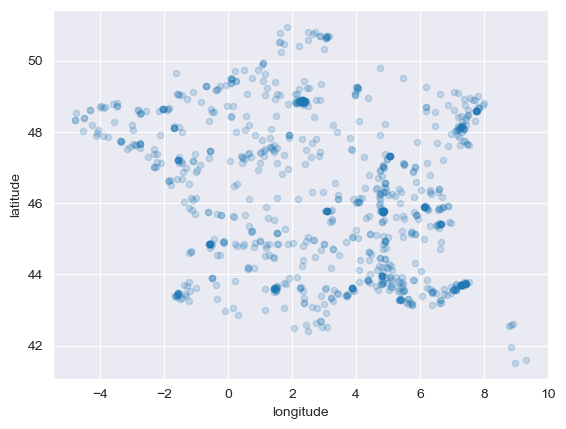

In [58]:
france_data.plot(kind='scatter', x='longitude', y='latitude', alpha=0.2)

Now these datapoints looks a lot more like France!

There are clusters in the Côte d'Azur, following the Rhone and in Paris

In [59]:
# Create a color map
colormap = branca.colormap.LinearColormap(colors=['lightblue','yellow','orange', 'red'],
                                          index=[0.5,1,2,3], # Define the index for the colors
                                          vmin=0,
                                          vmax=3)


# Create a map centered around the UK
france_map = folium.Map(location=[46.603354, 1.888334], tiles='Stamen Terrain', zoom_start=6)

# Add a legend
colormap.caption = 'Michelin Stars'
france_map.add_child(colormap)

# Add a marker for each point in your data
for idx, row in france_data.iterrows():
    folium.CircleMarker(
        location=(row['latitude'], row['longitude']),
        radius=3,
        color=colormap(row['stars']),  # Use the 'stars' value to determine the color
        fill=True,
        fill_opacity=0.1  # Control the opacity here
    ).add_to(france_map)

# Add the color map legend to the map
colormap.add_to(france_map)

# Display the map (commented out)
#france_map

Static image of the above plot.

Running in own Jupyter environment allows interactivity

![img](../../Images/Static_france.png)

----
&nbsp;
## Partitioning the data regionally.

#### Creating new columns `department` & `region`

We import the `departments.csv` data which was created in `Data_preparation.ipynb`

In [60]:
departments = pd.read_csv("../../data/France/departments.csv")
departments.head()

,department_num,department,region
0,01,Ain,Auvergne-Rhône-Alpes
1,02,Aisne,Hauts-de-France
2,03,Allier,Auvergne-Rhône-Alpes
3,04,Alpes-de-Haute-Provence,Provence-Alpes-Côte d'Azur
4,05,Hautes-Alpes,Provence-Alpes-Côte d'Azur


We first check the French data for the format of addresses in Monaco

In [61]:
monaco = france_data[france_data['city'] == 'Monaco']
monaco

,name,address,city,country,price,price_num,cuisine,url,award,stars,longitude,latitude
16,Le Louis XV - Alain Ducasse à l'Hôtel de Paris,"Place du Casino, Monaco, 98000, France",Monaco,France,€€€€,4,"Mediterranean Cuisine, Modern Cuisine",https://www.ducasse-paris.com/,3 MICHELIN Stars,3.0,7.427105,43.739184
75,Le Blue Bay,"40 avenue Princesse-Grace, Monaco, 98000, France",Monaco,France,€€€€,4,Creative,https://www.montecarlosbm.com/fr/restaurant-mo...,2 MICHELIN Stars,2.0,7.437975,43.748897
409,Le Grill,"Place du Casino, Monaco, 98000, France",Monaco,France,€€€€,4,Classic Cuisine,https://www.montecarlosbm.com/fr/restaurant-mo...,1 MICHELIN Star,1.0,7.427100,43.739367
426,Yoshi,"4 avenue de la Madone, Monaco, 98000, France",Monaco,France,€€€€,4,Japanese,http://www.metropole.com/fr,1 MICHELIN Star,1.0,7.427975,43.740818
455,"Pavyllon, un restaurant de Yannick Alléno, Mon...","Square Beaumarchais, Monaco, 98000, France",Monaco,France,€€€€,4,"Modern Cuisine, Creative",https://www.montecarlosbm.com/fr,1 MICHELIN Star,1.0,7.425868,43.738462
489,La Table d'Antonio Salvatore au Rampoldi,"3 avenue des Spélugues, Monaco, 98000, France",Monaco,France,€€€€,4,"Italian, Creative",http://www.rampoldi.mc/la-table-dantonio-salva...,1 MICHELIN Star,1.0,7.427820,43.740456


We create a copy and extract the first two digits of code postal in `address`

In [62]:
france_data = france_data.copy()
france_data['department_num'] = france_data['address'].str.extract(r'(\b\d{5}\b)', expand=False).str[:2]

#### We now merge `france_data` and `departments` on `department_num`

In [63]:
france_data = france_data.merge(departments, on='department_num', how='left')
print(france_data.columns.tolist())

['name', 'address', 'city', 'country', 'price', 'price_num', 'cuisine', 'url', 'award', 'stars', 'longitude', 'latitude', 'department_num', 'department', 'region']


In [64]:
france_data = france_data[['name', 'address', 'city', 'department_num', 'department', 'region',
                           'country', 'price', 'price_num', 'cuisine', 'url', 'award', 'stars', 'longitude', 'latitude']]
france_data.head()

,name,address,city,department_num,department,region,country,price,price_num,cuisine,url,award,stars,longitude,latitude
0,La Vague d'Or - Cheval Blanc St-Tropez,"Plage de la Bouillabaisse, Saint-Tropez, 83990...",Saint-Tropez,83,Var,Provence-Alpes-Côte d'Azur,France,€€€€,4,"Creative, Modern Cuisine",https://www.chevalblanc.com/fr/maison/st-tropez/,3 MICHELIN Stars,3.0,6.626154,43.266585
1,René et Maxime Meilleur,"Hameau de Saint-Marcel, Saint-Martin-de-Belle...",Saint-Martin-de-Belleville,73,Savoie,Auvergne-Rhône-Alpes,France,€€€€,4,"Creative, Regional Cuisine",https://www.la-bouitte.com/fr/,3 MICHELIN Stars,3.0,6.513306,45.369046
2,Kei,"5 rue du Coq-Héron, Paris, 75001, France",Paris,75,Paris,Île-de-France,France,€€€€,4,"Modern Cuisine, Creative",https://www.restaurant-kei.fr/,3 MICHELIN Stars,3.0,2.342285,48.864395
3,Auberge du Vieux Puits,"5 avenue Saint-Victor, Fontjoncouse, 11360, Fr...",Fontjoncouse,11,Aude,Occitanie,France,€€€€,4,Creative,https://www.aubergeduvieuxpuits.fr/fr/,3 MICHELIN Stars,3.0,2.789329,43.048173
4,Régis et Jacques Marcon,"Larsiallas, Saint-Bonnet-le-Froid, 43290, France",Saint-Bonnet-le-Froid,43,Haute-Loire,Auvergne-Rhône-Alpes,France,€€€€,4,Creative,https://www.lesmaisonsmarcon.fr/,3 MICHELIN Stars,3.0,4.434268,45.138673


We now create 2 more dataframes; `paris` and `rest_of_france`

In [65]:
paris = france_data[france_data['city'] == 'Paris']
rest_of_france = france_data[france_data['city'] != 'Paris']

In [66]:
paris.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159 entries, 2 to 1026
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            159 non-null    object 
 1   address         159 non-null    object 
 2   city            159 non-null    object 
 3   department_num  159 non-null    object 
 4   department      159 non-null    object 
 5   region          159 non-null    object 
 6   country         159 non-null    object 
 7   price           159 non-null    object 
 8   price_num       159 non-null    int64  
 9   cuisine         159 non-null    object 
 10  url             153 non-null    object 
 11  award           159 non-null    object 
 12  stars           159 non-null    float64
 13  longitude       159 non-null    float64
 14  latitude        159 non-null    float64
dtypes: float64(3), int64(1), object(11)
memory usage: 19.9+ KB


#### We may further sub-divide paris by arrondissements. Only `url` has missing values

In [67]:
rest_of_france.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 880 entries, 0 to 1038
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            880 non-null    object 
 1   address         880 non-null    object 
 2   city            880 non-null    object 
 3   department_num  880 non-null    object 
 4   department      874 non-null    object 
 5   region          874 non-null    object 
 6   country         880 non-null    object 
 7   price           880 non-null    object 
 8   price_num       880 non-null    int64  
 9   cuisine         880 non-null    object 
 10  url             842 non-null    object 
 11  award           880 non-null    object 
 12  stars           880 non-null    float64
 13  longitude       880 non-null    float64
 14  latitude        880 non-null    float64
dtypes: float64(3), int64(1), object(11)
memory usage: 110.0+ KB


#### `rest_of_france` has some null values for `department` and `region`

In [68]:
# Select rows where 'department' and 'region' are NaN
rest_of_france_null = france_data[(france_data['department'].isnull()) & (france_data['region'].isnull())]
rest_of_france_null

,name,address,city,department_num,department,region,country,price,price_num,cuisine,url,award,stars,longitude,latitude
39,Casadelmar,"7 km par route de la plage de Palombaggia, Por...",Porto-Vecchio,20,NaN,NaN,France,€€€€,4,Modern Cuisine,https://www.casadelmar.fr/fr/,2 MICHELIN Stars,2.0,9.309977,41.594810
249,A Casa di Ma,"Route de Calvi, Lumio, 20260, France",Lumio,20,NaN,NaN,France,€€€€,4,Modern Cuisine,https://www.acasadima.com/,1 MICHELIN Star,1.0,8.831886,42.581304
279,La Table de la Ferme,"Vallée de l'Ortolo, domaine de Murtoli, Murtol...",Murtoli,20,NaN,NaN,France,€€€€,4,"Modern Cuisine, Corsican",https://www.murtoli.com/,1 MICHELIN Star,1.0,8.946903,41.522976
525,La Signoria,"Route de la Forêt-de-Bonifato, Calvi, 20260, F...",Calvi,20,NaN,NaN,France,€€€€,4,Modern Cuisine,https://www.hotel-la-signoria.com/,1 MICHELIN Star,1.0,8.784631,42.536832
818,U Licettu,"Plaine de Cuttoli, Cuttoli, 20167, France",Cuttoli,20,NaN,NaN,France,€€,2,Traditional Cuisine,https://www.u-licettu.com/,Bib Gourmand,0.5,8.845830,41.963936
984,A Mandria di Pigna,"Village, Pigna, 20220, France",Pigna,20,NaN,NaN,France,€€,2,Corsican,https://www.restaurantpigna.com/,Bib Gourmand,0.5,8.903190,42.598780


`department_num` 20 represents Corsica.

Strictly there are two departments, 2A and 2B. This level of detail is not required

In [69]:
# Filter rows where 'department_num' is 20
france_data.loc[france_data['department_num'] == '20', 'department'] = 'Corse'
france_data.loc[france_data['department_num'] == '20', 'region'] = 'Corse'

# We split by city != Paris again
rest_of_france = france_data[france_data['city'] != 'Paris']

In [70]:
rest_of_france.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 880 entries, 0 to 1038
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            880 non-null    object 
 1   address         880 non-null    object 
 2   city            880 non-null    object 
 3   department_num  880 non-null    object 
 4   department      880 non-null    object 
 5   region          880 non-null    object 
 6   country         880 non-null    object 
 7   price           880 non-null    object 
 8   price_num       880 non-null    int64  
 9   cuisine         880 non-null    object 
 10  url             842 non-null    object 
 11  award           880 non-null    object 
 12  stars           880 non-null    float64
 13  longitude       880 non-null    float64
 14  latitude        880 non-null    float64
dtypes: float64(3), int64(1), object(11)
memory usage: 110.0+ KB


Again, `url` has some missing values.

The data is cleaned, split and ready for further analysis

----
&nbsp;
## Analysis by Region

In [71]:
print(len(france_data))
france_data.head()

1039


,name,address,city,department_num,department,region,country,price,price_num,cuisine,url,award,stars,longitude,latitude
0,La Vague d'Or - Cheval Blanc St-Tropez,"Plage de la Bouillabaisse, Saint-Tropez, 83990...",Saint-Tropez,83,Var,Provence-Alpes-Côte d'Azur,France,€€€€,4,"Creative, Modern Cuisine",https://www.chevalblanc.com/fr/maison/st-tropez/,3 MICHELIN Stars,3.0,6.626154,43.266585
1,René et Maxime Meilleur,"Hameau de Saint-Marcel, Saint-Martin-de-Belle...",Saint-Martin-de-Belleville,73,Savoie,Auvergne-Rhône-Alpes,France,€€€€,4,"Creative, Regional Cuisine",https://www.la-bouitte.com/fr/,3 MICHELIN Stars,3.0,6.513306,45.369046
2,Kei,"5 rue du Coq-Héron, Paris, 75001, France",Paris,75,Paris,Île-de-France,France,€€€€,4,"Modern Cuisine, Creative",https://www.restaurant-kei.fr/,3 MICHELIN Stars,3.0,2.342285,48.864395
3,Auberge du Vieux Puits,"5 avenue Saint-Victor, Fontjoncouse, 11360, Fr...",Fontjoncouse,11,Aude,Occitanie,France,€€€€,4,Creative,https://www.aubergeduvieuxpuits.fr/fr/,3 MICHELIN Stars,3.0,2.789329,43.048173
4,Régis et Jacques Marcon,"Larsiallas, Saint-Bonnet-le-Froid, 43290, France",Saint-Bonnet-le-Froid,43,Haute-Loire,Auvergne-Rhône-Alpes,France,€€€€,4,Creative,https://www.lesmaisonsmarcon.fr/,3 MICHELIN Stars,3.0,4.434268,45.138673


In [72]:
print(len(paris))
paris.head()

159


,name,address,city,department_num,department,region,country,price,price_num,cuisine,url,award,stars,longitude,latitude
2,Kei,"5 rue du Coq-Héron, Paris, 75001, France",Paris,75,Paris,Île-de-France,France,€€€€,4,"Modern Cuisine, Creative",https://www.restaurant-kei.fr/,3 MICHELIN Stars,3.0,2.342285,48.864395
11,Le Pré Catelan,"Route de Suresnes - bois de Boulogne, Paris, 7...",Paris,75,Paris,Île-de-France,France,€€€€,4,"Modern Cuisine, Classic Cuisine",https://www.leprecatelan.com/,3 MICHELIN Stars,3.0,2.250718,48.863937
13,Épicure,"Le Bristol, 112 rue du Faubourg-Saint-Honoré, ...",Paris,75,Paris,Île-de-France,France,€€€€,4,Modern Cuisine,https://www.oetkercollection.com/fr/hotels/le-...,3 MICHELIN Stars,3.0,2.314625,48.871762
14,Arpège,"84 rue de Varenne, Paris, 75007, France",Paris,75,Paris,Île-de-France,France,€€€€,4,Creative,https://www.alain-passard.com/,3 MICHELIN Stars,3.0,2.316965,48.855731
15,L'Ambroisie,"9 place des Vosges, Paris, 75004, France",Paris,75,Paris,Île-de-France,France,€€€€,4,Classic Cuisine,https://www.ambroisie-paris.com/,3 MICHELIN Stars,3.0,2.364521,48.855494


----
&nbsp;
### Importing the departemental demographics data

In [73]:
demographics = pd.read_csv("../../data/France/demographics.csv")

In [74]:
demographics.head()

,department_num,department,region,population,population_density,area_sq_km
0,01,Ain,Auvergne-Rhône-Alpes,652432,114.2,5713.06
1,02,Aisne,Hauts-de-France,531345,71.9,7390.06
2,03,Allier,Auvergne-Rhône-Alpes,335975,45.7,7351.75
3,04,Alpes-de-Haute-Provence,Provence-Alpes-Côte d'Azur,164308,23.9,6874.81
4,05,Hautes-Alpes,Provence-Alpes-Côte d'Azur,141220,25.3,5581.82


To visualise the demographics data, we require a GeoJSON file of the departmental boundaries of metropolitan France

Credit: [gregoiredavid.github](https://github.com/gregoiredavid/france-geojson)

In [75]:
# Load the GeoJSON file
gdf = gpd.read_file('../../data/France/departements.geojson')

# Print the first few rows
gdf.head()

,code,nom,geometry
0,01,Ain,"POLYGON ((4.78021 46.17668, 4.78024 46.18905, ..."
1,02,Aisne,"POLYGON ((3.17296 50.01131, 3.17382 50.01186, ..."
2,03,Allier,"POLYGON ((3.03207 46.79491, 3.03424 46.79080, ..."
3,04,Alpes-de-Haute-Provence,"POLYGON ((5.67604 44.19143, 5.67817 44.19051, ..."
4,05,Hautes-Alpes,"POLYGON ((6.26057 45.12685, 6.26417 45.12641, ..."


We can join the geoJSON data on `code` and delete the `nom` column

In [76]:
# Merge dataframes
merged = gdf.set_index('code').join(demographics.set_index('department_num'))

# Delete 'nom' column in place
merged.drop(columns='nom', inplace=True)

print(len(merged))
merged.head()

96


,geometry,department,region,population,population_density,area_sq_km
code,,,,,,
01,"POLYGON ((4.78021 46.17668, 4.78024 46.18905, ...",Ain,Auvergne-Rhône-Alpes,652432,114.2,5713.06
02,"POLYGON ((3.17296 50.01131, 3.17382 50.01186, ...",Aisne,Hauts-de-France,531345,71.9,7390.06
03,"POLYGON ((3.03207 46.79491, 3.03424 46.79080, ...",Allier,Auvergne-Rhône-Alpes,335975,45.7,7351.75
04,"POLYGON ((5.67604 44.19143, 5.67817 44.19051, ...",Alpes-de-Haute-Provence,Provence-Alpes-Côte d'Azur,164308,23.9,6874.81
05,"POLYGON ((6.26057 45.12685, 6.26417 45.12641, ...",Hautes-Alpes,Provence-Alpes-Côte d'Azur,141220,25.3,5581.82


----
&nbsp;
### Creating Visualisation of `population` & `population_density`

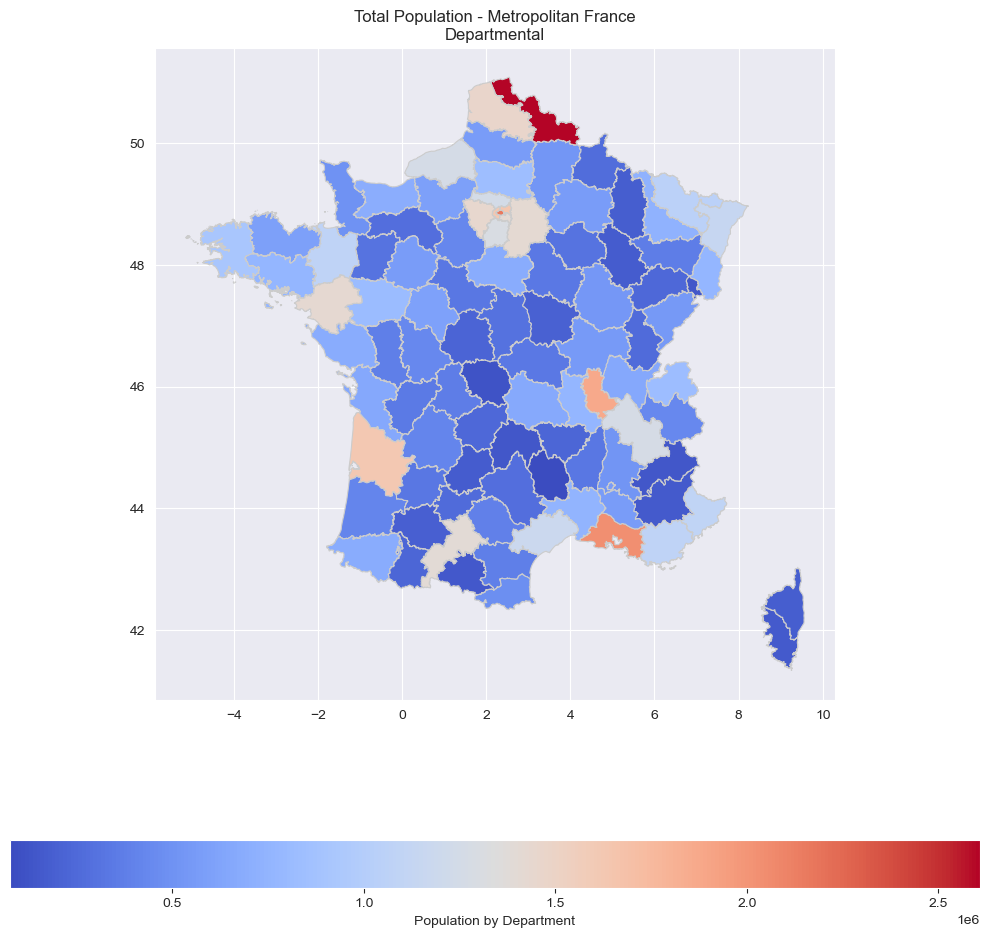

In [88]:
# Plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# Create map
merged.plot(column='population',
            cmap='coolwarm',
            linewidth=0.8,
            ax=ax,
            edgecolor='0.8',
            legend=True,
            legend_kwds={'label': "Population by Department",
                         'orientation': "horizontal"})
plt.title("Total Population - Metropolitan France\nDepartmental")
plt.tight_layout()
plt.show()

#### There's a huge range of values in `population_density` therefore we apply a log transformation

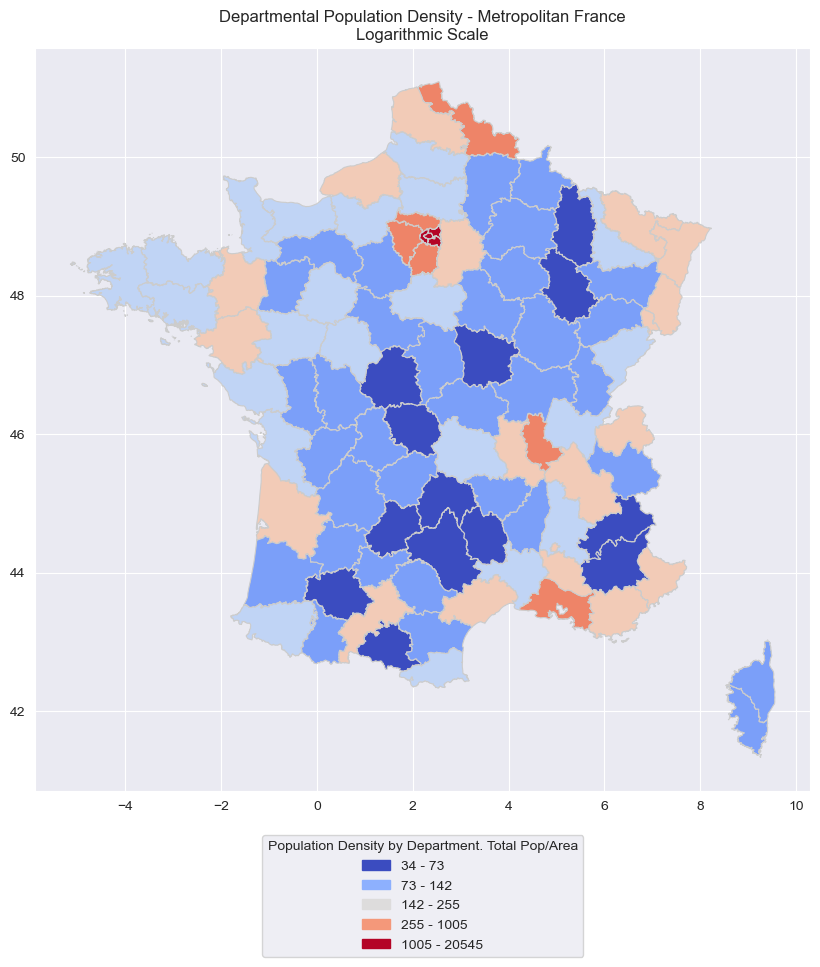

In [48]:
# Apply log transformation to the density column
merged['log_population_density'] = np.log(merged['population_density'] + 1)  # Add 1 or a small constant to avoid log(0)

# Define classification scheme
classifier = mapclassify.NaturalBreaks(merged['log_population_density'], k=6)  # Use NaturalBreaks instead of Quantiles

# Apply classification to dataframe
merged['classification'] = merged[['log_population_density']].apply(classifier)

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Create map
merged.plot(column='classification',
            cmap='coolwarm',
            linewidth=0.8,
            ax=ax,
            edgecolor='0.8',
            legend=False) # we will create a custom legend

# Create legend
labels = []
# Create a list of bin boundaries in original scale
bin_edges_exp = np.exp(classifier.bins) - 1
for i in range(len(bin_edges_exp) - 1):
    label = f"{bin_edges_exp[i]:.0f} - {bin_edges_exp[i+1]:.0f}"
    labels.append(mpatches.Patch(color=plt.cm.coolwarm(i / (len(bin_edges_exp) - 2)),
                                 label=label))
plt.legend(handles=labels,
           title='Population Density by Department. Total Pop/Area',
           bbox_to_anchor=(0.5, -0.05),
           loc='upper center')
plt.title("Departmental Population Density - Metropolitan France\nLogarithmic Scale")
plt.show()